<a href="https://colab.research.google.com/github/abhiram212/Resume/blob/main/Task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-14-c280976b7a73>:34: DeprecationWarning:

write_transaction has been renamed to execute_write



Large Price Jumps:
            timestamp stock_symbol       price  volume  price_diff
1 2025-03-20 01:00:00         AAPL  151.256986    1316   -3.186011
5 2025-03-20 05:00:00         AAPL  154.203082    1280    3.158892
7 2025-03-20 07:00:00         AAPL  151.920438    1723   -1.552820
8 2025-03-20 08:00:00         AAPL  154.159369    1847    2.238931
9 2025-03-20 09:00:00         AAPL  150.236078    1026   -3.923291
Missing Trades:
Empty DataFrame
Columns: [timestamp, stock_symbol, price, volume, price_diff, timestamp_diff]
Index: []
Trades Deviating from Expected Patterns:
Empty DataFrame
Columns: [timestamp, stock_symbol, price, volume, price_diff, timestamp_diff]
Index: []


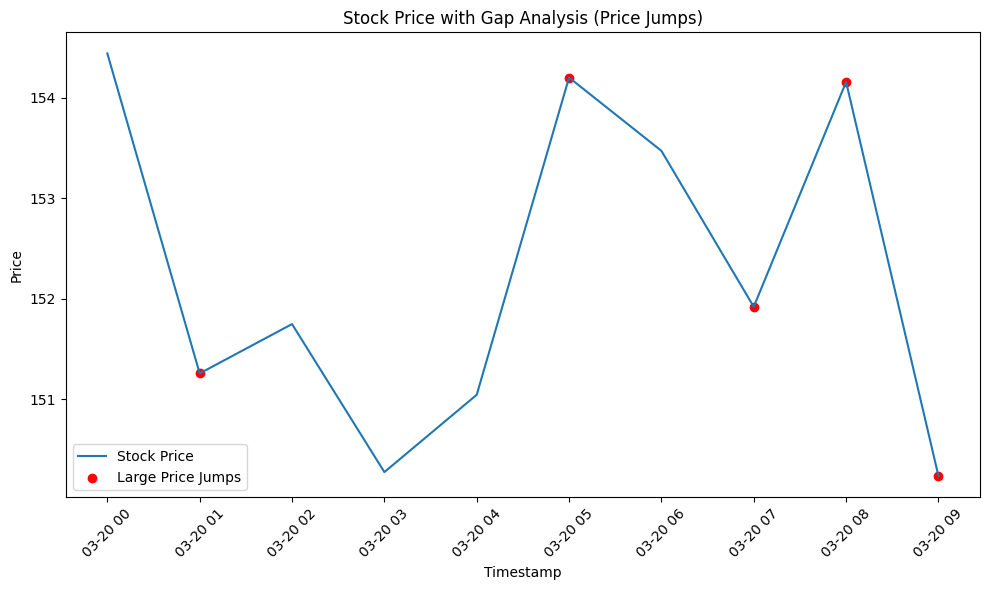

<ipython-input-14-c280976b7a73>:109: DeprecationWarning:

read_transaction has been renamed to execute_read



In [ ]:
# Step 1: Install necessary libraries
!pip install neo4j pandas numpy matplotlib plotly

# Step 2: Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from neo4j import GraphDatabase

# Step 3: Sample data (you can replace this with your CSV data loading process)

data = pd.read_csv('stock_trades.csv')

df = pd.DataFrame(data)
uri = "neo4j+s://40eee460.databases.neo4j.io"
username = "neo4j"
password = "hvMg8ZEdGfpcoVII-o5uL4JrHyyvSskncn7FChEYjmw"

# Initialize Neo4j driver
driver = GraphDatabase.driver(uri, auth=(username, password))

# Step 5: Insert stock trade data into Neo4j
def create_trade(tx, timestamp, stock_symbol, price, volume):
    query = (
        "CREATE (t:Trade {timestamp: $timestamp, stock_symbol: $stock_symbol, "
        "price: $price, volume: $volume})"
    )
    tx.run(query, timestamp=timestamp, stock_symbol=stock_symbol, price=price, volume=volume)

# Insert trades into Neo4j
with driver.session() as session:
    for _, row in df.iterrows():
        session.write_transaction(create_trade, row['timestamp'], row['stock_symbol'], row['price'], row['volume'])

# Step 6: Perform Gap Analysis
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Calculate the price difference between consecutive trades
df['price_diff'] = df['price'].diff()

# Identify large price jumps (e.g., price difference > 1.5)
large_jumps = df[df['price_diff'].abs() > 1.5]

# Detect missing trades by checking for gaps in timestamps (e.g., more than 1 hour gap)
df['timestamp_diff'] = df['timestamp'].diff()
missing_trades = df[df['timestamp_diff'] > pd.Timedelta('1 hour')]

print("Large Price Jumps:")
print(large_jumps)

print("Missing Trades:")
print(missing_trades)

# Step 7: Comparison with Expected Patterns
expected_price_range = (150, 155)  # Expected price range for the stock (e.g., AAPL)
expected_volume_range = (1000, 2000)  # Expected volume range

# Identify trades that deviate from the expected patterns
deviations = df[
    (df['price'] < expected_price_range[0]) |
    (df['price'] > expected_price_range[1]) |
    (df['volume'] < expected_volume_range[0]) |
    (df['volume'] > expected_volume_range[1])
]

print("Trades Deviating from Expected Patterns:")
print(deviations)

# Step 8: Visualization of Stock Price Over Time with Gaps Highlighted

# Plot stock prices over time and highlight large price jumps
plt.figure(figsize=(10, 6))
plt.plot(df['timestamp'], df['price'], label='Stock Price')
plt.scatter(large_jumps['timestamp'], large_jumps['price'], color='red', label='Large Price Jumps')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.title('Stock Price with Gap Analysis (Price Jumps)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Step 9: Interactive Visualization with Plotly
fig = px.line(df, x='timestamp', y='price', title="Stock Price Over Time")
fig.add_scatter(x=large_jumps['timestamp'], y=large_jumps['price'], mode='markers', name='Large Price Jumps', marker=dict(color='red'))
fig.show()

# Step 10: (Optional) Query Neo4j for the stock trade graph
# count = 0
arr = [];
def query_trades(tx):
    query = """
    MATCH (t:Trade)
    RETURN t.timestamp, t.stock_symbol, t.price, t.volume
    ORDER BY t.timestamp
    """
    result = tx.run(query)
    for record in result:
      if record['t.timestamp']!=None:
        arr.append((
                record['t.timestamp'],
                record['t.stock_symbol'],
                record['t.price'],
                record['t.volume']
            ))

with driver.session() as session:
    session.read_transaction(query_trades)